In [1]:
import io
import requests
import pandas as pd
from nilearn.image import resample_to_img, math_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
import nibabel as nb
from gzip import GzipFile
from nimare.meta.ibma import stouffers, weighted_stouffers
from nilearn.masking import apply_mask
from nilearn.plotting import plot_roi, plot_stat_map, plot_glass_brain

template_nii = load_mni152_template()
template_mask_nii = load_mni152_brain_mask()

C:\Users\me\Miniconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


This tutorial shows how to use NeuroVault API and NiMARE to perfroma a metaanalysis on a set of single subject maps

## Defining which images will be used in the metaanalysis
We begin by creating a helper function to get metadata for all images that are part of a set of collections we are interested in

In [2]:
def get_images_metadata(collection_ids):
    images = []
    for collection_id in collection_ids:
        url = "http://neurovault.org/api/collections/%d/images/?format=json"%collection_id
        while url:
            r = requests.get(url)
            d = r.json()
            images += d['results']
            url = d['next']
    return pd.DataFrame(images)

In this excercise we are coing to use only one collection but this list can be extended to multiple collections

In [3]:
collection_ids = [3235]

In [4]:
all_images_df = get_images_metadata(collection_ids)
all_images_df.columns

Index(['BMI', 'SDS-BMI', 'add_date', 'age', 'analysis_level', 'bis11_score',
       'bis_bas_score', 'brain_coverage', 'cognitive_contrast_cogatlas',
       'cognitive_contrast_cogatlas_id', 'cognitive_paradigm_cogatlas',
       'cognitive_paradigm_cogatlas_id', 'cognitive_paradigm_description_url',
       'collection', 'collection_id', 'contrast_definition',
       'contrast_definition_cogatlas', 'data_origin',
       'days_since_menstruation', 'description', 'ethnicity', 'fat_percentage',
       'figure', 'file', 'file_size', 'gender', 'handedness',
       'hours_since_last_meal', 'id', 'image_type', 'is_thresholded',
       'is_valid', 'map_type', 'mean_PDS_score', 'modality', 'modify_date',
       'name', 'not_mni', 'number_of_subjects', 'perc_bad_voxels',
       'perc_voxels_outside', 'race', 'reduced_representation',
       'smoothness_fwhm', 'spsrq_score', 'statistic_parameters',
       'subject_species', 'surface_left_file', 'surface_right_file',
       'tanner_stage', 'target_

The function returns a Pandas DataFrame with all metadata associated with the images. This way we can filter what images should go into our metaanalysis. We will only use single subject maps from this collection

In [5]:
ss_images_df = all_images_df[all_images_df.analysis_level == 'single-subject']
ss_images_df.describe()

,BMI,age,brain_coverage,collection_id,file_size,id,number_of_subjects,perc_bad_voxels,perc_voxels_outside
count,67.00000,122.000000,122.000000,122.0,122.000000,122.000000,122.0,122.000000,122.000000
mean,23.19194,33.516885,90.553975,3235.0,112867.745902,108309.500000,1.0,76.678171,8.238074
std,1.93002,23.084441,2.953555,0.0,4457.423544,35.362409,0.0,0.923337,2.965284
min,19.52000,8.430000,80.609283,3235.0,102708.000000,108249.000000,1.0,74.379708,2.867370
25%,21.69500,14.737500,89.051625,3235.0,109903.000000,108279.250000,1.0,76.130732,5.964508
50%,23.37000,26.615000,91.130076,3235.0,112553.500000,108309.500000,1.0,76.698576,8.218514
75%,24.54000,59.022500,92.200343,3235.0,115561.750000,108339.750000,1.0,77.239783,10.027860
max,26.93000,76.060000,96.642300,3235.0,124164.000000,108370.000000,1.0,78.883639,17.852171


## Performing the metaanalysis
We begin by defining a helper function that takes a Dataframe of selected images and performs Stouffer's metaanalysis on them.

**Disclaimer: the maps in this example are T maps which is technically incorrect for this technique. Without knowing the first level desing it is impossible to asses the degrees of freedom and convert them to Z maps, but for the sake of this excercise we will assume T == Z**

In [6]:
def perform_metaanalysis(images_df):
    z_imgs = []
    for i, row in images_df.iterrows():
        download_url = row['file']
        print("Downloading %s"%download_url)
        r = requests.get(download_url)
        fp = io.BytesIO(r.content)
        gzfileobj = GzipFile(filename="tmp.nii.gz", mode='rb', fileobj=fp)
        nii = nb.Nifti1Image.from_file_map({'image': nb.FileHolder("tmp.nii.gz", gzfileobj)})

        # making sure all images have the same size
        resampled_nii = resample_to_img(nii, template_nii)
        z_imgs.append(resampled_nii)

    z_data = apply_mask(z_imgs, template_mask_nii)
    results = stouffers(z_data, template_mask_nii, inference='ffx', null='theoretical', corr='FWE', two_sided=True)
    return results

The above function downloads the selected maps and resamples them to match dimensions of the MNI template. Let's run it!

In [7]:
results = perform_metaanalysis(ss_images_df)

c:\gdrive\workspace\megaanalysis\src\nimare\nimare\meta\ibma\ibma.py:240: RuntimeWarning: divide by zero encountered in log10


In [8]:
results.images.keys()

dict_keys(['z', 'p', 'log_p'])

No we can plot the statistically significan ROIs

C:\Users\me\Miniconda3\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


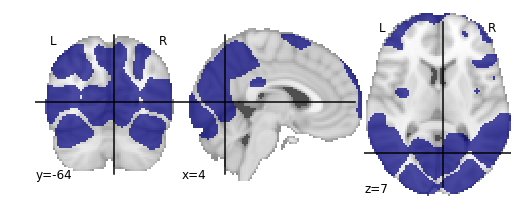

In [9]:
plot_roi(math_img(formula = '(a < 0.05)*mask', a=results.images['p'], mask=template_mask_nii))

## Filtering with metadata
Because the DataFrame includes metadata we can use them to filter the images going into the metaanalysis. Lets showcase this, by redoing the above metaanalysis only with data from participants over 18 years old.

In [10]:
ss_above_18_df = ss_images_df[ss_images_df.age > 18]

In [11]:
len(ss_above_18_df)

68

c:\gdrive\workspace\megaanalysis\src\nimare\nimare\meta\ibma\ibma.py:240: RuntimeWarning: divide by zero encountered in log10
C:\Users\me\Miniconda3\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


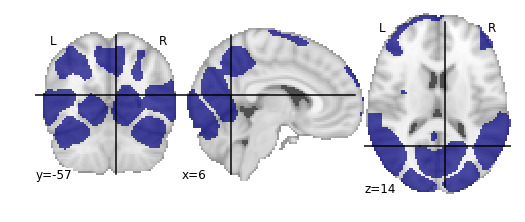

In [12]:
results = perform_metaanalysis(ss_above_18_df)
plot_roi(math_img(formula = '(a < 0.05)*mask', a=results.images['p'], mask=template_mask_nii))